# Yield Curve Strategies & Mean Reversion 


In [14]:
!pip install --upgrade mplfinance

In [15]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.random import randn
import itertools
import datetime
import matplotlib.pyplot as plt
import math

import mplfinance as mpf
import matplotlib.dates as mpl_dates
import seaborn as sns

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm
import statsmodels.tsa.stattools as ts

%matplotlib inline

In [16]:
def cagr(returns, resolution):
   return np.prod(1+returns)**(resolution/len(returns))-1

def mdd(returns):
  cum_rets = (1 + returns).cumprod()
  max_cumret = cum_rets.cummax()
  drawdown = 1 - cum_rets / max_cumret
  return np.max(drawdown)

def sharpe(returns, riskfreerate = 0, resolution = 365):
  return np.sqrt(resolution) * (np.mean(returns) - riskfreerate/resolution) / (np.std(returns))

## Ornstein-Uhlenbeck Process and Parameter Determination

The spread $s$ is the difference between the longer-maturity bond yield $r_l$ and the shorter-maturity bond yield $r_s$.
The longer-maturity bond yield can be approximated as following Brownian motion.
The spread can therefore be modelled as mean-reverting and, in particular, as an Ornstein-Uhlenbeck process.
$$ ds(t) = \theta_s(\mu_s - s(t)) dt + \sigma_s dW_s(t)$$
$$ dr_l(t) = \sigma_l dW_l(t)$$
$$ E[dW_l(t) dW_s(t)]=0$$


When we wish to simulate this process, we use a differencing formula:
$$S_i - s_{i-1} = \theta_s(\mu - S_i) (t_i - t_{i-1}) + \sigma_s\sqrt{t_i - t_{i-1}}W_t$$

The optimal parameters can be calculated analytically, following the method presented in *Optimal Mean Reversion Trading: Mathematical Analysis And Practical Applications* by Tim Siu-tang Leung, Xin Li.

First define (for any mean-reverting OU process $x$),

$$
X_x = \sum_{i=1}^N x_{i-1}
$$

$$
X_y = \sum_{i=1}^N x_i
$$

$$
X_{xx} = \sum_{i=1}^N (x_{i-1})^2
$$

$$
X_{xy} = \sum_{i=1}^N x_{i-1} x_i
$$

$$
X_{yy} = \sum_{i=1}^N (x_i)^2
$$

The optimal parameters are given by,


$$
\theta^* = \frac{X_y X_{xx} - X_x X_{xy}}
{N(X_{xx} - X_{xy}) - (X_x^2 - X_xX_y)}
$$

$$
\mu^* = -\frac{1}{\Delta t} \ln\left(
\frac{X_{xy} - \theta^*X_x - \theta^*X_y + N(\theta^*)^2}
{X_{xx} - 2\theta^*X_x + N(\theta^*)^2}\right)
$$


\begin{multline}
(\sigma^*)^2 = \frac{2\mu^*}{N(1-e^{-2\mu^*\Delta t})} (X_{yy} - 2e^{-\mu^*\Delta t} X_{xy} + e^{-2\mu^*\Delta t}X_{xx} \\
- 2\theta^* (1-e^{-\mu^*\Delta t})(X_y - e^{-\mu^*\Delta t})X_x + N(\theta^*)^2(1-e^{-\mu^*\Delta t})^2)
\end{multline}

In [17]:
def log_likelihood( parameters, S, dt ):
    theta = parameters[0]
    mu = parameters[1]
    sigma = parameters[2]

    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt( sigma0 )

    N = S.size

    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma0)

    prefactor = -1 / (2 * N * sigma0**2)
    sum_term = 0
    for i in range( 1, N ):
        x2 = S[i]
        x1 = S[i-1]

        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) - \
                   theta * (1-np.exp(-mu*dt)))**2

    f = (term1 + term2 + prefactor * sum_term)

    return f

def calculate_parameters(x, dt):

    N =x.size

    Xx  = np.sum(x[0:-1])
    Xy  = np.sum(x[1:])
    Xxx = np.sum(x[0:-1]**2)
    Xxy = np.sum(x[0:-1] * x[1:])
    Xyy = np.sum(x[1:]**2)

    theta0 = (Xy * Xxx - Xx * Xxy) / (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy) )

    mu0 = (Xxy - theta0 * Xx - theta0 * Xy + N * theta0**2) / \
        (Xxx - 2 * theta0 * Xx + N * theta0**2)
    mu0 = -1 / dt * np.log(mu0)

    prefactor = 2 * mu0 / (N*(1-np.exp(-2*mu0*dt)))
    term = Xyy - 2*np.exp(-mu0*dt) * Xxy + np.exp(-2*mu0*dt) * Xxx - 2*theta0*(1-np.exp(-mu0*dt)) * (Xy - Xx * np.exp(-mu0*dt)) + N * theta0**2 * ( 1-np.exp(-mu0 * dt))**2

    sigma02 = prefactor * term
    sigma0 = np.sqrt(sigma02)

    return theta0, mu0, sigma0

##  Pairs Price

Our $X$ values will be the price of the pair over some range of time.

$$
X^{\alpha, \beta}_t = \alpha S_t^{(1)} - \beta S_t^{(2)}
$$

where $S_t^{(1)}$ and $S_t^{(2)}$ are the prices of the long and short maturity bonds, respectively.  Likewise, $\alpha$ and $\beta$ are the amounts of $S^{(1)}$ and $S^{(2)}$ owned.

For each potential pair, in other words for different values of $\alpha$ and $\beta$, we will use historical data to generate the OU parameters.

We will then sweep the values for $\alpha$ and $\beta$ (actually the ratio) and find the values that maximize the log likelihood.  We fix $\alpha$ and sweep $\beta$.

If we put $A$ dollars in $S^{(1)}$ we have
$$
\alpha = \frac{A}{S_0^{(1)}}.
$$

$$
\beta = \frac{B}{S_0^{(2)}}.
$$

The calculations are in dollar amounts.  Since we only care about a ratio, we can set $A=1$.  When we do the calculation, we can sweep the parameters by taking a range of the ratio $B/A$.  We will take $B/A$ in 0.001 increments ($0.001, 0.002,\dots 1$).

## Application to bonds

In [18]:
BRA = pd.read_csv('./Brazil_data.csv')
dates=pd.to_datetime(BRA.iloc[:,0])
BRA.iloc[:,0]=dates
for i in range (1,len(BRA.columns)):
  BRA.iloc[:,i] = BRA.iloc[:,i].str.rstrip('%').astype('float') / 100.0
BRA.set_index('Date', inplace=True, verify_integrity=True)
BRA

,9M Yield,1 Yr Yield,2 Yr Yield,3 Yr Yield,5 Yr Yield,8 Yr Yield,10 Yr Yield
Date,,,,,,,
2015-03-02,0.1306,0.1318,0.1297,0.1270,0.1269,0.1251,0.1246
2015-03-03,0.1306,0.1315,0.1302,0.1275,0.1267,0.1256,0.1257
2015-03-04,0.1326,0.1328,0.1314,0.1285,0.1281,0.1268,0.1277
2015-03-05,0.1334,0.1337,0.1324,0.1296,0.1295,0.1280,0.1285
2015-03-06,0.1346,0.1355,0.1349,0.1320,0.1312,0.1294,0.1299
...,...,...,...,...,...,...,...
2024-02-14,0.1020,0.1003,0.0989,0.0995,0.1037,0.1060,0.1075
2024-02-15,0.1021,0.1002,0.0949,0.1003,0.1044,0.1070,0.1079
2024-02-16,0.1037,0.1002,0.0951,0.1004,0.1046,0.1069,0.1074


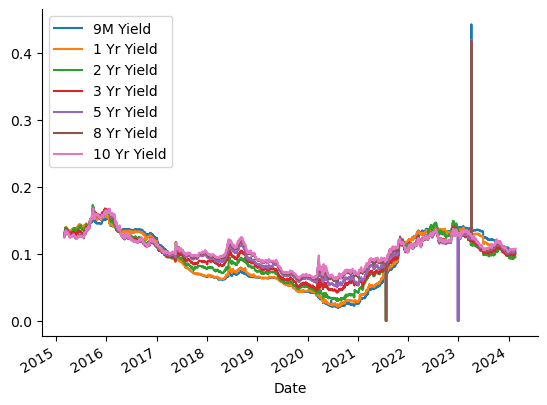

In [19]:
# Yields over time
df=BRA
df.plot(kind='line')
plt.gca().spines[['top', 'right']].set_visible(False)

In [20]:
# Data cleaning
# Remove outliers

In [21]:
BRA_9M=BRA.iloc[:, 0]
BRA_1Y=BRA.iloc[:, 1]
BRA_2Y=BRA.iloc[:, 2]
BRA_3Y=BRA.iloc[:, 3]
BRA_5Y=BRA.iloc[:, 4]
BRA_8Y=BRA.iloc[:, 5]
BRA_10Y=BRA.iloc[:, 6]

In [22]:
def augmented_dickey_fuller(data,n):
    """
    Carry out the Augmented Dickey-Fuller test with a lag order value of n.

    Parameters
    ----------
    data : data
    n : lag order value

    Returns
    -------
    Augmented Dickey-Fuller test
    """
    return ts.adfuller(data, 1)

In [23]:
df=BRA
window=50
cols=df.columns
col_names=cols.values.tolist()
ncols=len(col_names)
dict_diffs={}
maturities_ind=[]
adf_list=[]
for i in range (0,ncols):
  for j in range (i+1,ncols):
    rs=df.iloc[:, i]
    rl=df.iloc[:, j]
    diff=rl-rs
    maturities_label=col_names[i]+"-"+col_names[j]
    maturities_ind.append((i,j)) #Stores indices of pairs in original dataframe
    dict_diffs[maturities_label]=diff
    adf_list.append(augmented_dickey_fuller(diff,1))

diffs_df=pd.DataFrame(dict_diffs)
diffs_df

,9M Yield-1 Yr Yield,9M Yield-2 Yr Yield,9M Yield-3 Yr Yield,9M Yield-5 Yr Yield,9M Yield-8 Yr Yield,9M Yield-10 Yr Yield,1 Yr Yield-2 Yr Yield,1 Yr Yield-3 Yr Yield,1 Yr Yield-5 Yr Yield,1 Yr Yield-8 Yr Yield,...,2 Yr Yield-3 Yr Yield,2 Yr Yield-5 Yr Yield,2 Yr Yield-8 Yr Yield,2 Yr Yield-10 Yr Yield,3 Yr Yield-5 Yr Yield,3 Yr Yield-8 Yr Yield,3 Yr Yield-10 Yr Yield,5 Yr Yield-8 Yr Yield,5 Yr Yield-10 Yr Yield,8 Yr Yield-10 Yr Yield
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-02,0.0012,-0.0009,-0.0036,-0.0037,-0.0055,-0.0060,-0.0021,-0.0048,-0.0049,-0.0067,...,-0.0027,-0.0028,-0.0046,-0.0051,-0.0001,-0.0019,-0.0024,-0.0018,-0.0023,-0.0005
2015-03-03,0.0009,-0.0004,-0.0031,-0.0039,-0.0050,-0.0049,-0.0013,-0.0040,-0.0048,-0.0059,...,-0.0027,-0.0035,-0.0046,-0.0045,-0.0008,-0.0019,-0.0018,-0.0011,-0.0010,0.0001
2015-03-04,0.0002,-0.0012,-0.0041,-0.0045,-0.0058,-0.0049,-0.0014,-0.0043,-0.0047,-0.0060,...,-0.0029,-0.0033,-0.0046,-0.0037,-0.0004,-0.0017,-0.0008,-0.0013,-0.0004,0.0009
2015-03-05,0.0003,-0.0010,-0.0038,-0.0039,-0.0054,-0.0049,-0.0013,-0.0041,-0.0042,-0.0057,...,-0.0028,-0.0029,-0.0044,-0.0039,-0.0001,-0.0016,-0.0011,-0.0015,-0.0010,0.0005
2015-03-06,0.0009,0.0003,-0.0026,-0.0034,-0.0052,-0.0047,-0.0006,-0.0035,-0.0043,-0.0061,...,-0.0029,-0.0037,-0.0055,-0.0050,-0.0008,-0.0026,-0.0021,-0.0018,-0.0013,0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-14,-0.0017,-0.0031,-0.0025,0.0017,0.0040,0.0055,-0.0014,-0.0008,0.0034,0.0057,...,0.0006,0.0048,0.0071,0.0086,0.0042,0.0065,0.0080,0.0023,0.0038,0.0015
2024-02-15,-0.0019,-0.0072,-0.0018,0.0023,0.0049,0.0058,-0.0053,0.0001,0.0042,0.0068,...,0.0054,0.0095,0.0121,0.0130,0.0041,0.0067,0.0076,0.0026,0.0035,0.0009
2024-02-16,-0.0035,-0.0086,-0.0033,0.0009,0.0032,0.0037,-0.0051,0.0002,0.0044,0.0067,...,0.0053,0.0095,0.0118,0.0123,0.0042,0.0065,0.0070,0.0023,0.0028,0.0005


In [24]:
#Check which pairs are mean-reverting to 10% confidence
ten_percent_thresh=adf_list[0][4]['10%']
mean_rev_pairs=[]
for pair in range(len(adf_list)):
  test_stat=adf_list[pair][0]
  if test_stat<ten_percent_thresh:
    mean_rev_pairs.append(maturities_ind[pair])
mean_rev_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 4),
 (3, 5),
 (3, 6),
 (4, 5),
 (4, 6),
 (5, 6)]

In [25]:
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = np.log(np.cumsum(randn(100000))+1000)
mr = np.log(randn(100000)+1000)
tr = np.log(np.cumsum(randn(100000)+1)+1000)

# Output the Hurst Exponent for each of the above series
print("Hurst(GBM):   %s" % hurst(gbm))
print("Hurst(MR):    %s" % hurst(mr))
print("Hurst(TR):    %s" % hurst(tr))

Hurst(GBM):   0.5013586966032556
Hurst(MR):    0.00011113181362505531
Hurst(TR):    0.955756317644055


In [26]:
#Find most mean-reverting pair
hurst_diffs=hurst(diffs_df)
ind_most=np.argmin(hurst_diffs)
short_ind=maturities_ind[ind_most][0]
long_ind=maturities_ind[ind_most][1]
short_bond=df.iloc[:, short_ind]
long_bond=df.iloc[:, long_ind]

/var/folders/7s/0ct0t68d3nndpfvmjbz549z00000gn/T/ipykernel_2408/455906290.py:19: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]


In [28]:
BRA_price_10YR = pd.read_csv('./BRA_price_10YR_3875.csv')
df=BRA_price_10YR
df=df.drop(['ISIN','Unnamed: 3'],axis=1)
df.columns = ['date','close']
df=df.drop(list(range(5)))
dates=pd.to_datetime(df.iloc[:,0],dayfirst=True)
df.iloc[:,0]=dates
df.set_index('date', inplace=True, verify_integrity=True)
df=df.astype(float)
df.head(6)

,close
date,
2020-06-11,98.976997
2020-06-12,95.842003
2020-06-15,96.185997
2020-06-16,96.431000
2020-06-17,97.281998
2020-06-18,96.862999


In [29]:
#5 YR data as 8 YR lacking
BRA_price_5YR = pd.read_csv('./BRA_price_5YR.csv')
df2=BRA_price_5YR

df2=df2.drop(['ISIN','Unnamed: 3'],axis=1)
df2.columns = ['date','close']
df2=df2.drop(list(range(5)))
dates=pd.to_datetime(df2.iloc[:,0],dayfirst=True)
df2.iloc[:,0]=dates
df2.set_index('date', inplace=True, verify_integrity=True)
df2=df2.astype(float)
df2.head(6)

,close
date,
2020-06-11,99.425003
2020-06-12,98.292000
2020-06-15,98.793999
2020-06-16,98.933998
2020-06-17,99.463997
2020-06-18,99.143997


In [30]:
#Combine data frames for pair
#Same data range
df_pair=pd.DataFrame({'10YR-3.875':df.iloc[:,0],'5YR-2.875':df2.iloc[:,0]},index=df.index)
df_pair.head()


,10YR-3.875,5YR-2.875
date,,
2020-06-11,98.976997,99.425003
2020-06-12,95.842003,98.292000
2020-06-15,96.185997,98.793999
2020-06-16,96.431000,98.933998
2020-06-17,97.281998,99.463997


            10YR-3.875  5YR-2.875    spread  spread_mean  spread_std  \
date                                                                   
2023-11-23   88.553001  95.797997  7.244996     8.202120    0.686151   
2023-11-24   88.435997  95.839996  7.403999     8.210120    0.674123   
2023-11-27   88.444000  95.781998  7.337998     8.216740    0.663610   
2023-11-28   88.789001  95.857002  7.068001     8.215960    0.664963   
2023-11-29   89.355003  96.101997  6.746994     8.210660    0.675724   
2023-11-30   89.596001  96.141998  6.545997     8.192680    0.707716   
2023-12-01   89.333000  96.112999  6.779999     8.172580    0.733339   
2023-12-04   89.800003  96.176003  6.376000     8.145340    0.773981   
2023-12-05   89.582001  96.172997  6.590996     8.121940    0.802981   
2023-12-06   89.879997  96.279999  6.400002     8.092240    0.838597   
2023-12-07   89.959999  96.275002  6.315003     8.056520    0.875444   
2023-12-08   89.891998  96.290001  6.398003     8.027200    0.90

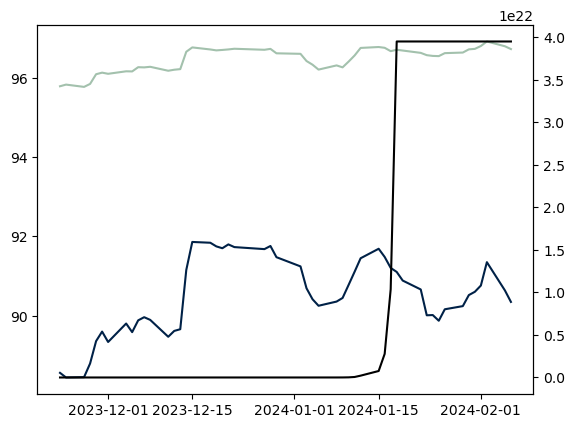

In [50]:
##

window = 50
entryzscore = 1
exitzscore = 0.5
trading_cost = 0.0000
b1=df_pair.columns[0]
b2=df_pair.columns[1]
df_pair["spread"] = df_pair[b2] - df_pair[b1]
df_pair["spread_mean"] = df_pair["spread"].rolling(window).mean()
df_pair["spread_std"] = df_pair["spread"].rolling(window).std()
df_pair["RET1"] = df_pair[b1].pct_change().shift(-1)
df_pair["RET2"] = df_pair[b2].pct_change().shift(-1)
df_pair["spread_zscore"] = (df_pair["spread"] - df_pair["spread_mean"]) / df_pair["spread_std"]
df_pair.dropna(inplace = True)

## Determine holdings based on strategy

df_pair["position2"] = np.NaN
df_pair.loc[df_pair["spread_zscore"] > entryzscore,"position2"] = -0.5
df_pair.loc[df_pair["spread_zscore"] < -entryzscore,"position2"] = 0.5
df_pair.loc[np.abs(df_pair["spread_zscore"]) < exitzscore,"position2"] = 0
df_pair["position2"].fillna(method = "ffill", inplace = True)
df_pair["position1"] = -df_pair["position2"]

## Calculate returns

df_rets = df_pair[[b1, b2]].rename(columns = {b1: "one", b2: "two"})
df_weights = df_pair[["position1", "position2"]].rename(columns = {"position1": "one", "position2": "two"})

rets = (df_rets * df_weights).sum(axis=1).fillna(0)
print(df_rets * df_weights)
costs = df_weights.diff().abs().sum(axis=1).fillna(0)
print(costs)
costs.iloc[0] = df_weights.iloc[0].sum()
rets = rets - trading_cost * costs

df_pair['Portfolio'] = np.cumprod(1+rets)

## Plot results

print('The Sharpe ratio of our strategy is {}.'.format(round(sharpe(rets, 0.025, 365), 3)))
print('The maximum drawdown is {}.'.format(round(mdd(rets), 3)))

fig, ax = plt.subplots(1, 1)

ax.plot(df_pair[b1], color='#002147')
ax.plot(df_pair[b2], color='#A3C1AD')

ax1 = ax.twinx()
ax1.plot(df_pair['Portfolio'], color='black')


In [41]:
dt = 1/365
df_pair

,10YR-3.875,5YR-2.875,spread,spread_mean,spread_std,RET1,RET2,spread_zscore,position2,position1,Portfolio
date,,,,,,,,,,,
2021-12-24,96.612999,101.483000,4.870001,3.785140,0.943691,-0.001749,-0.000719,1.149594,-0.5,0.5,-1.435001e+00
2021-12-27,96.444000,101.410000,4.966000,3.828520,0.947187,0.003567,0.000818,1.200904,-0.5,0.5,2.128106e+00
2021-12-28,96.788002,101.493000,4.704998,3.862580,0.947478,0.003069,0.001310,0.889116,-0.5,0.5,-2.878261e+00
2021-12-29,97.084999,101.626000,4.541001,3.888720,0.947812,-0.000659,0.000167,0.688197,-0.5,0.5,3.656832e+00
2021-12-30,97.021004,101.643000,4.621996,3.913360,0.950592,0.002010,0.000089,0.745468,-0.5,0.5,-4.794099e+00
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-13,90.318001,96.802002,6.484001,5.876159,0.586366,-0.002857,-0.001126,1.036625,-0.5,0.5,-5.371893e+173
2024-02-14,90.059998,96.693001,6.633003,5.873219,0.582095,0.001754,0.000548,1.305258,-0.5,0.5,1.244400e+174
2024-02-15,90.218002,96.746002,6.528000,5.876259,0.585163,0.000277,-0.000093,1.113777,-0.5,0.5,-2.817321e+174


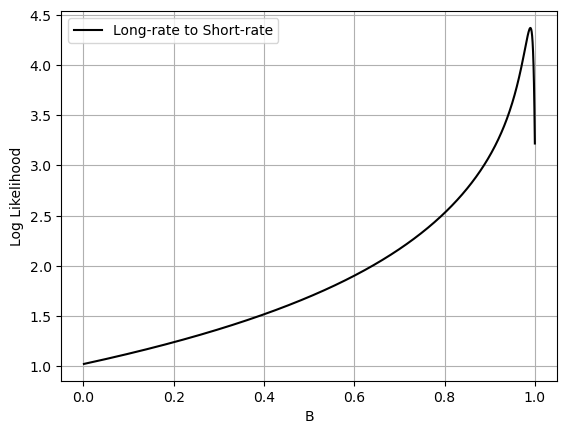

In [58]:
# Maximise log-likehood test
B_over_A = np.linspace(0.001, 1, 1000)
likelihood = []

alpha=1/df_pair[b1].iloc[0]
b2_1=df_pair[b2].iloc[0]

for value in B_over_A:
    beta = value / b2_1

    X = alpha * df_pair[b1] - beta * df_pair[b2]

    parameters = calculate_parameters(X, dt)
    likelihood.append(log_likelihood(parameters, X, dt))


B = B_over_A * 1 # Set A=1 above
plt.plot(B, likelihood, 'k', label = 'Long-rate to Short-rate')
plt.xlabel('B')
plt.ylabel('Log Likelihood')
plt.grid()
plt.legend()

In [62]:
# Find value of B which maximises the log likelihood
V = np.amax(likelihood)
ind = np.where(likelihood == V)
ind = ind[0]
print('Long vs short rate optimal ratio', B[ind][0] )

Long vs short rate optimal ratio 0.99


# Unneeded code

In [ ]:
#Modelling longer-maturity bond as Brownian and spread as an OU process
#Expanding average
rs=BRA_9M
rl=BRA_1Y
diff=rl-rs
diff_shift=diff.shift(1)
mu_diff=diff.expanding().mean()
var_diff=diff.expanding().var()
cov_diffs=diff.expanding().cov(diff_shift)
theta_diff=np.log(var_diff/cov_diffs)
std_diff=np.sqrt(2*theta_diff*var_diff)
volatil_long=np.sqrt((np.square(mu_diff-rl)).expanding().mean())
diff_params=pd.DataFrame({"date":dates,"difference":diff,"mu":mu_diff,"OU theta": theta_diff,"OU std Difference":std_diff,"Volatility Long": volatil_long, "var Difference":var_diff})

diff_params

In [ ]:
# date vs difference
import seaborn as sns
def _plot_series(series, series_index=0):
  xs = series['date']
  diffs = series['difference']
  mus=series['mu']

  plt.plot(xs, mus, label="Mu")
  plt.plot(xs, diffs, label="Difference")

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = diff_params.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
plt.legend()

In [ ]:
cols=BRA.columns
col_names=cols.values.tolist()
ncols=len(col_names)
dict_vars={}
maturities_ind=[]
for i in range (0,ncols):
  for j in range (i+1,ncols):
    rs=BRA.iloc[:, i]
    rl=BRA.iloc[:, j]
    diff=rl-rs
    diff_shift=diff.shift(1)
    mu_diff=diff.expanding().mean()
    var_diff=diff.expanding().var()
    maturities_label=col_names[i]+"-"+col_names[j]
    maturities_ind.append((i,j))
    dict_vars[maturities_label]=var_diff

variances_diffs=pd.DataFrame(dict_vars)
variances_diffs

In [ ]:
short_ind=maturities_ind[ind][0]
long_ind=maturities_ind[ind][1]
short_bond=BRA.iloc[:, short_ind]
long_bond=BRA.iloc[:, long_ind]

In [ ]:
#Smallest variance series
# variances_diffs.describe()
means=variances_diffs.mean(axis=0)
# print(means)
name_min=means.idxmin()
ind=means.index.get_loc(name_min)